## Group members
Oda Grauff Erntsen 490130

Marte Vingsnes 521488

Malin Døskeland 527204

Kaggle team name: The Data Divas

## Imports

In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import column_stack
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
optimizer = tf.keras.optimizers.legacy.Adam(...)
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from scipy.stats import gmean
import logging
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)



## Constants

In [157]:
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 10

root = os.getcwd()


## Load and Process Data
Tried different resampling and cleaning of the data

In [158]:
def aggregate_data(df):
    df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')

    df.set_index('hourly_timestamp', inplace=True)

    aggregations = {col: 'median' for col in df.columns if col != 'date_forecast'}
    aggregations['date_forecast'] = 'first'

    df = df.groupby('hourly_timestamp').agg(aggregations).reset_index()

    df.drop(columns=['hourly_timestamp'], inplace=True)
    df['date_forecast'] = df['date_forecast'].dt.floor('H')
    
    return df

In [ ]:
# Resampling based on description of each feature
'''
def resample_and_clean(dataset, time_freq='H', set_index=None):
    if set_index:
        dataset = dataset.set_index(set_index)
    
    dataset.index = pd.to_datetime(dataset.index)
        
    agg_methods = {
        'absolute_humidity_2m:gm3': 'mean',
        'air_density_2m:kgm3': 'mean',
        'ceiling_height_agl:m': 'mean',
        'clear_sky_energy_1h:J': 'last',
        'clear_sky_rad:W': 'sum',
        'cloud_base_agl:m': 'mean',
        'dew_or_rime:idx': 'last',
        'dew_point_2m:K': 'mean',
        'diffuse_rad:W': 'sum',
        'diffuse_rad_1h:J': 'last', 
        'direct_rad:W': 'sum',
        'direct_rad_1h:J': 'last', 
        'effective_cloud_cover:p': 'mean',
        'elevation:m': 'mean', 
        'fresh_snow_12h:cm': 'last',
        'fresh_snow_24h:cm': 'last',
        'fresh_snow_3h:cm': 'last',
        'fresh_snow_6h:cm': 'last',
        'fresh_snow_1h:cm': 'last',
        'is_day:idx': 'last',
        'is_in_shadow:idx': 'last',
        'msl_pressure:hPa': 'mean',
        'precip_5min:mm' : 'sum',
        'precip_type_5min:idx': 'last',
        'pressure_100m:hPa': 'mean',
        'pressure_50m:hPa': 'mean',
        'prob_rime:p': 'last',
        'rain_water:kgm2': 'sum', 
        'relative_humidity_1000hPa:p': 'mean', 
        'sfc_pressure:hPa': 'mean',
        'snow_density:kgm3': 'mean', 
        'snow_depth:cm': 'mean',
        'snow_drift:idx': 'mean',
        'snow_melt_10min:mm': 'sum', 
        'snow_water:kgm2': 'sum',
        'sun_azimuth:d': 'mean',
        'sun_elevation:d': 'mean',
        'super_cooled_liquid_water:kgm2': 'mean', 
        't_1000hPa:K': 'mean',
        'total_cloud_cover:p': 'mean', 
        'visibility:m': 'mean', 
        'wind_speed_10m:ms': 'mean',
        'wind_speed_u_10m:ms': 'mean', 
        'wind_speed_v_10m:ms': 'mean',
        'wind_speed_w_1000hPa:ms': 'mean',
    }    

    resampled_data = dataset.resample(time_freq).agg(agg_methods)

    # Drop specified columns
    columns_to_drop = ['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3']
    resampled_data2 = resampled_data.drop(columns=columns_to_drop)

    return resampled_data2.dropna(thresh=42)
    '''

In [159]:
def clean_aggregated_data(df):
    #df = add_date_features(df.copy())
    df.drop(columns=['snow_density:kgm3'], inplace=True)
    
    if "date_calc" in df.columns:
        df.drop(columns=['date_calc'], inplace=True)
    return df

In [161]:
def visualize_pv_measurement(merged_data):
    plt.figure(figsize=(10, 5))
    plt.plot(merged_data['date_forecast'], merged_data['pv_measurement'])
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.grid(True)
    plt.show()

### Removal of noise functions
Our exploration of the data shows that there were noise in the measurements, which lead to functions for removing this noise

In [162]:
def mark_consecutive_identical(series, threshold=23):
    """Mark sequences of threshold or more identical consecutive values with NaN"""
    series_copy = series.copy()
    
    diff = series_copy.diff().ne(0)
    
    count = (~diff).groupby(diff.cumsum()).cumsum()
    
    series_copy[count >= threshold] = np.nan
    
    return series_copy

def drop_noise_in_pv_measurement(merged_data):
    merged_data['pv_measurement'] = mark_consecutive_identical(merged_data['pv_measurement'])
    
    merged_data.dropna(subset=['pv_measurement'], inplace=True)
    
    return merged_data

### Removal of correlated features functions
The feature exploration also showed that severeal of the features were highly correlated which we tried to drop

In [163]:
columns_to_drop = [ 
            'elevation:m',
            'is_day:idx',
            'snow_density:kgm3',
            'snow_drift:idx',
            'dew_point_2m:K',
            't_1000hPa:K',
            'clear_sky_rad:W',
            'diffuse_rad_1h:J',
            'direct_rad_1h:J',
            'total_cloud_cover:p',
            'pressure_100m:hPa',
            'pressure_50m:hPa',
            'sfc_pressure:hPa'
        ]

def drop_correlated_columns(data):

    for e in columns_to_drop:
        data.drop(columns=e, inplace=True, errors='ignore')

    return data

### Processing of data
This part combines all of our preprocessing

In [164]:
def process(data, targets, visualize=False):
    aggregated_data = aggregate_data(data.copy())
    
    aggregated_data = clean_aggregated_data(aggregated_data)
    
    merged_data = aggregated_data.merge(targets[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    drop_noise_in_pv_measurement(merged_data)

    drop_correlated_columns(merged_data)

    #if visualize:
        #visualize_pv_measurement(merged_data)

    y = merged_data["pv_measurement"]
    X = merged_data.drop(columns=['pv_measurement', 'date_forecast', 'time'])
    return X, y

In [165]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
a_targets = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
b_targets = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
c_targets = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
X_train_observed_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
X_train_observed_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
X_train_observed_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))

# validation data
X_train_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
X_train_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
X_train_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))

# test data
X_test_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
X_test_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
X_test_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))

In [166]:
X_train_A, y_train_A = process(X_train_observed_a, a_targets, visualize=True)
X_val_A, y_val_A = process(X_train_estimated_a, a_targets)

X_test_A = aggregate_data(X_test_estimated_a.copy())
X_test_A = clean_aggregated_data(X_test_A.copy())
X_test_A = drop_correlated_columns(X_test_A.copy())
X_test_A.drop(columns=['date_forecast'], inplace=True)


In [167]:
X_train_B, y_train_B = process(X_train_observed_b, b_targets, visualize=True)
X_val_B, y_val_B = process(X_train_estimated_b, b_targets)

X_test_B = aggregate_data(X_test_estimated_b.copy())
X_test_B = clean_aggregated_data(X_test_B.copy())
X_test_B = drop_correlated_columns(X_test_B.copy())
X_test_B.drop(columns=['date_forecast'], inplace=True)

In [168]:
X_train_C, y_train_C = process(X_train_observed_c, c_targets, visualize=True)
X_val_C, y_val_C = process(X_train_estimated_c, c_targets)

X_test_C = aggregate_data(X_test_estimated_c.copy())
X_test_C = clean_aggregated_data(X_test_C.copy())
X_test_C = drop_correlated_columns(X_test_C.copy())
X_test_C.drop(columns=['date_forecast'], inplace=True)

## Feature exploration
Here we found the highly correlated features which we chose to drop above

In [ ]:
# Checks for location A in this code, the same has been done for B and C
column_names = X_train_observed_a.columns

for i, e in enumerate(column_names):
    
    if e == "date_forecast": continue

    feature_name = e

    fig, ax = plt.subplots(figsize=(15, 4))

    print(feature_name)

    X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=ax, title='Train/Test A', color='red', label='Observed A')
    X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=ax, color='blue', label='Estimated A')
    X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=ax, color='green', label='Test A')

    ax.legend()

    plt.show()

In [ ]:
correlation_matrix = X_train_observed_a.corr()
plt.figure(figsize=(20, 20))
mask = abs(correlation_matrix) > 0.8
sns.heatmap(correlation_matrix, mask=~mask, annot=True, cmap='coolwarm', linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation matrix of the features')
plt.show()

In [ ]:
threshold = 0.8

columns = correlation_matrix.columns 

highly_correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((columns[i], columns[j], correlation_matrix.iloc[i, j]))

print("Highly correlated pairs of features (above threshold of {}):".format(threshold))
for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

## Handle Missing Values
To handle missing values we have tried several techniques, both replacing them with mean and a combination of forward-backward fill

In [ ]:
def replace_nan_with_mean(df):
    for column in df.columns:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
    return df

In [169]:
def forward_backward_fill(X):
    print(type(X))
    X['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
    X['ceiling_height_agl:m'].fillna(method='bfill', inplace=True)
    
    X['cloud_base_agl:m'].fillna(method='ffill', inplace=True)
    X['cloud_base_agl:m'].fillna(method='bfill', inplace=True)
    
    return X


In [170]:
handle_nan = forward_backward_fill

X_train_A = handle_nan(X_train_A)
X_val_A = handle_nan(X_val_A)
X_test_A = handle_nan(X_test_A)

X_train_B = handle_nan(X_train_B)
X_val_B = handle_nan(X_val_B)
X_test_B = handle_nan(X_test_B)

X_train_C = handle_nan(X_train_C)
X_val_C = handle_nan(X_val_C)
X_test_C = handle_nan(X_test_C)



<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_35477/3996943496.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_35477/3996943496.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['ceiling_height_agl:m'].fillna(method='bfill', inplace=True)
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_35477/3996943496.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['cloud_base_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_35477/3996943496.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

## Normalize Data
Since we chose to implement a Neural Network it was necessary to scale the data, we tried other scalers as well but robust was the best one. The other ones we tried were MinMaxScaler and StandardScaler

In [171]:
scaler = RobustScaler()
X_train_A = scaler.fit_transform(X_train_A)
X_val_A = scaler.transform(X_val_A)
X_test_A = scaler.transform(X_test_A)

In [172]:
scaler = RobustScaler()
X_train_B = scaler.fit_transform(X_train_B)
X_val_B = scaler.transform(X_val_B)
X_test_B = scaler.transform(X_test_B)

In [173]:
scaler = RobustScaler()
X_train_C = scaler.fit_transform(X_train_C)
X_val_C = scaler.transform(X_val_C)
X_test_C = scaler.transform(X_test_C)

## Create and Train MLP Model
We wanted to try a combination of a neural network and other models, so we implemented a MLP model. Additionally did we use optuna to do hyperparameter tuning so that we could stack several models. All of the code from this exploration is added below.

In [174]:
def create_mlp(input_shape, lr, weights):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(units=weights, activation='relu'))
    model.add(Dense(units=weights//2, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_absolute_error')
    return model

In [175]:
def train_and_save_mlp_model(X_train, y_train, X_val, y_val, model_save_path, lr, weights, patience=10, epochs=100, batch_size=32):
    input_shape = X_train.shape[1:]
    model = create_mlp(input_shape, lr, weights)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    location = model_save_path.split('_')[-1].split('.')[0]
    print("-------------------------------")
    print("Training model for location:", location)
    print("-------------------------------")
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stop])
    model.save(os.path.join(root, model_save_path))
    return model

In [176]:
def train_multiple_models(X_train, y_train, X_val, y_val, model_save_path, hyperparams_list):
    models = []
    for i, hyperparams in enumerate(hyperparams_list):
        print(f"Training model {i+1}/{len(hyperparams_list)} with hyperparameters: {hyperparams}")
        model = train_and_save_mlp_model(X_train, y_train, X_val, y_val, f"{model_save_path}_model_{i+1}.h5", **hyperparams)
        models.append(model)
    return models


## Hyperparameter tuning with optuna

In [ ]:
def objective(trial, X_train, y_train, X_val, y_val, model_save_path):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weights = trial.suggest_int("weights", 32, 256, step=32)
    
    input_shape = X_train.shape[1:]
    model = create_mlp(input_shape, lr, weights)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    
    return min(history.history["val_loss"])

In [ ]:
def optimize_and_save_best_models(X_train, y_train, X_val, y_val, model_save_path, n_trials=1000):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, model_save_path), n_trials=n_trials)
    
    for i in range(5):
        trial = study.trials[i]
        model_path = f"{model_save_path}_best_{i+1}.h5"
        input_shape = X_train.shape[1:]
        best_model = create_mlp(input_shape, trial.params["lr"], trial.params["weights"])
        best_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=0)
        best_model.save(model_path)
    
    return study



In [ ]:
study_A = optimize_and_save_best_models(X_train_A, y_train_A, X_val_A, y_val_A, 'models/model_location_A')
study_B = optimize_and_save_best_models(X_train_B, y_train_B, X_val_B, y_val_B, 'models/model_location_B')
study_C = optimize_and_save_best_models(X_train_C, y_train_C, X_val_C, y_val_C, 'models/model_location_C')

print("Best hyperparameters for location A:", study_A.best_params)
print("Best hyperparameters for location B:", study_B.best_params)
print("Best hyperparameters for location C:", study_C.best_params)


In [ ]:
def print_best_hyperparameters(study, location_name, top_k=10):
    best_trials = sorted(study.trials, key=lambda trial: trial.value)[:top_k]
    print(f"Best hyperparameters for location {location_name}:")
    for i, trial in enumerate(best_trials):
        print(f"Rank {i+1}")
        print(f" Loss: {trial.value}")
        print(f" Params: {trial.params}")
        print("\n")

print_best_hyperparameters(study_A, "A")
print_best_hyperparameters(study_B, "B")
print_best_hyperparameters(study_C, "C")


In [177]:
hyperparams_list_A = [
{'lr': 0.004473088493711625, 'weights': 32},
{'lr': 0.0053098477944254876, 'weights': 96},
{'lr': 0.008465707115576994, 'weights': 32},
{'lr': 0.005576715224447768, 'weights': 128},
{'lr': 0.005947010823550518, 'weights': 128}
]

hyperparams_list_B = [
{'lr': 0.0030129639140684533, 'weights': 256},
{'lr': 0.003893358549116366, 'weights': 128},
{'lr': 0.003731186390381951, 'weights': 128},
{'lr': 0.0025391065791536475, 'weights': 256},
{'lr': 0.0029584356432203686, 'weights': 128}
]


hyperparams_list_C = [
{'lr': 0.005927371786065072, 'weights': 64},
{'lr': 0.007074144306381341, 'weights': 25},
{'lr': 0.00454047427700079, 'weights': 128},
{'lr': 0.0074360786549823275, 'weights': 160},
{'lr': 0.006882815000916854, 'weights': 128}
]

# This is where we traiend the multiple models
models_A = train_multiple_models(X_train_A, y_train_A, X_val_A, y_val_A, 'models/model_location_A', hyperparams_list_A)
models_B = train_multiple_models(X_train_B, y_train_B, X_val_B, y_val_B, 'models/model_location_B', hyperparams_list_B)
models_C = train_multiple_models(X_train_C, y_train_C, X_val_C, y_val_C, 'models/model_location_C', hyperparams_list_C)

Training model 1/5 with hyperparameters: {'lr': 0.004473088493711625, 'weights': 32}
-------------------------------
Training model for location: 1
-------------------------------
Epoch 1/100
927/927 [==============================] - 1s 439us/step - loss: 276.0902 - val_loss: 138.1245
Epoch 2/100
927/927 [==============================] - 0s 382us/step - loss: 219.7957 - val_loss: 128.2468
Epoch 3/100
927/927 [==============================] - 0s 400us/step - loss: 214.8648 - val_loss: 125.2776
Epoch 4/100
927/927 [==============================] - 0s 377us/step - loss: 211.3756 - val_loss: 122.7772
Epoch 5/100
927/927 [==============================] - 0s 392us/step - loss: 208.1799 - val_loss: 116.1199
Epoch 6/100
927/927 [==============================] - 0s 381us/step - loss: 205.7984 - val_loss: 121.1661
Epoch 7/100
927/927 [==============================] - 0s 386us/step - loss: 203.7738 - val_loss: 113.7503
Epoch 8/100
927/927 [==============================] - 0s 381us/step - 

/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model 2/5 with hyperparameters: {'lr': 0.0053098477944254876, 'weights': 96}
-------------------------------
Training model for location: 2
-------------------------------
Epoch 1/100
927/927 [==============================] - 1s 469us/step - loss: 248.7746 - val_loss: 123.8853
Epoch 2/100
927/927 [==============================] - 0s 419us/step - loss: 211.2174 - val_loss: 117.4820
Epoch 3/100
927/927 [==============================] - 0s 418us/step - loss: 206.0809 - val_loss: 117.0215
Epoch 4/100
927/927 [==============================] - 0s 435us/step - loss: 203.5840 - val_loss: 118.0820
Epoch 5/100
927/927 [==============================] - 0s 414us/step - loss: 201.0128 - val_loss: 113.9838
Epoch 6/100
927/927 [==============================] - 0s 424us/step - loss: 198.4323 - val_loss: 113.8303
Epoch 7/100
927/927 [==============================] - 0s 430us/step - loss: 198.6653 - val_loss: 110.7719
Epoch 8/100
927/927 [==============================] - 0s 443us/step -

-------------------------------
Training model for location: 3
-------------------------------
Epoch 1/100
927/927 [==============================] - 1s 437us/step - loss: 251.6489 - val_loss: 130.2346
Epoch 2/100
927/927 [==============================] - 0s 412us/step - loss: 214.6574 - val_loss: 120.2957
Epoch 3/100
927/927 [==============================] - 0s 387us/step - loss: 208.4434 - val_loss: 118.9983
Epoch 4/100
927/927 [==============================] - 0s 385us/step - loss: 205.0314 - val_loss: 121.4515
Epoch 5/100
927/927 [==============================] - 0s 386us/step - loss: 204.1917 - val_loss: 112.7698
Epoch 6/100
927/927 [==============================] - 0s 384us/step - loss: 201.4026 - val_loss: 118.8891
Epoch 7/100
927/927 [==============================] - 0s 384us/step - loss: 200.2688 - val_loss: 119.1281
Epoch 8/100
927/927 [==============================] - 0s 386us/step - loss: 200.0700 - val_loss: 122.2882
Epoch 9/100
927/927 [============================

Training model 4/5 with hyperparameters: {'lr': 0.005576715224447768, 'weights': 128}
-------------------------------
Training model for location: 4
-------------------------------
Epoch 1/100
927/927 [==============================] - 1s 476us/step - loss: 241.4877 - val_loss: 127.0957
Epoch 2/100
927/927 [==============================] - 0s 422us/step - loss: 210.2975 - val_loss: 118.5712
Epoch 3/100
927/927 [==============================] - 0s 419us/step - loss: 205.0360 - val_loss: 113.7099
Epoch 4/100
927/927 [==============================] - 0s 477us/step - loss: 202.5206 - val_loss: 116.1236
Epoch 5/100
927/927 [==============================] - 0s 425us/step - loss: 200.1844 - val_loss: 126.4150
Epoch 6/100
927/927 [==============================] - 0s 427us/step - loss: 199.8098 - val_loss: 111.6690
Epoch 7/100
927/927 [==============================] - 0s 422us/step - loss: 197.8071 - val_loss: 113.9067
Epoch 8/100
927/927 [==============================] - 0s 421us/step -

Training model 5/5 with hyperparameters: {'lr': 0.005947010823550518, 'weights': 128}
-------------------------------
Training model for location: 5
-------------------------------
Epoch 1/100
927/927 [==============================] - 1s 474us/step - loss: 241.4766 - val_loss: 127.9883
Epoch 2/100
927/927 [==============================] - 0s 420us/step - loss: 210.6402 - val_loss: 115.0637
Epoch 3/100
927/927 [==============================] - 0s 447us/step - loss: 206.1591 - val_loss: 125.4051
Epoch 4/100
927/927 [==============================] - 0s 419us/step - loss: 204.0596 - val_loss: 121.8807
Epoch 5/100
927/927 [==============================] - 0s 421us/step - loss: 200.5072 - val_loss: 113.7890
Epoch 6/100
927/927 [==============================] - 0s 466us/step - loss: 200.2430 - val_loss: 115.2669
Epoch 7/100
927/927 [==============================] - 0s 478us/step - loss: 197.0024 - val_loss: 111.0433
Epoch 8/100
927/927 [==============================] - 0s 454us/step -

-------------------------------
Training model for location: 1
-------------------------------
Epoch 1/100
737/737 [==============================] - 1s 620us/step - loss: 37.6596 - val_loss: 18.5616
Epoch 2/100
737/737 [==============================] - 0s 561us/step - loss: 32.8180 - val_loss: 15.4272
Epoch 3/100
737/737 [==============================] - 0s 567us/step - loss: 32.1664 - val_loss: 15.6732
Epoch 4/100
737/737 [==============================] - 0s 557us/step - loss: 31.8221 - val_loss: 16.2589
Epoch 5/100
737/737 [==============================] - 0s 563us/step - loss: 31.6163 - val_loss: 16.2577
Epoch 6/100
737/737 [==============================] - 0s 563us/step - loss: 31.1216 - val_loss: 17.0088
Epoch 7/100
737/737 [==============================] - 0s 562us/step - loss: 30.7151 - val_loss: 15.6177
Epoch 8/100
737/737 [==============================] - 0s 567us/step - loss: 30.5459 - val_loss: 17.2854
Epoch 9/100
737/737 [==============================] - 0s 558us/s

Training model 2/5 with hyperparameters: {'lr': 0.003893358549116366, 'weights': 128}
-------------------------------
Training model for location: 2
-------------------------------
Epoch 1/100
737/737 [==============================] - 1s 507us/step - loss: 38.3507 - val_loss: 16.8151
Epoch 2/100
737/737 [==============================] - 0s 426us/step - loss: 32.6269 - val_loss: 15.6121
Epoch 3/100
737/737 [==============================] - 0s 425us/step - loss: 31.9730 - val_loss: 16.0933
Epoch 4/100
737/737 [==============================] - 0s 428us/step - loss: 31.8649 - val_loss: 16.6524
Epoch 5/100
737/737 [==============================] - 0s 428us/step - loss: 31.2149 - val_loss: 15.3273
Epoch 6/100
737/737 [==============================] - 0s 430us/step - loss: 31.2002 - val_loss: 16.3711
Epoch 7/100
737/737 [==============================] - 0s 449us/step - loss: 30.7000 - val_loss: 16.2669
Epoch 8/100
737/737 [==============================] - 0s 436us/step - loss: 30.3678

Training model 3/5 with hyperparameters: {'lr': 0.003731186390381951, 'weights': 128}
-------------------------------
Training model for location: 3
-------------------------------
Epoch 1/100
737/737 [==============================] - 0s 482us/step - loss: 38.0738 - val_loss: 16.2507
Epoch 2/100
737/737 [==============================] - 0s 426us/step - loss: 32.7262 - val_loss: 18.0406
Epoch 3/100
737/737 [==============================] - 0s 423us/step - loss: 32.0707 - val_loss: 16.3494
Epoch 4/100
737/737 [==============================] - 0s 423us/step - loss: 31.6616 - val_loss: 17.1143
Epoch 5/100
737/737 [==============================] - 0s 428us/step - loss: 31.2800 - val_loss: 16.4116
Epoch 6/100
737/737 [==============================] - 0s 424us/step - loss: 31.1111 - val_loss: 15.7853
Epoch 7/100
737/737 [==============================] - 0s 423us/step - loss: 30.8200 - val_loss: 17.1571
Epoch 8/100
737/737 [==============================] - 0s 457us/step - loss: 30.6260

Training model 4/5 with hyperparameters: {'lr': 0.0025391065791536475, 'weights': 256}
-------------------------------
Training model for location: 4
-------------------------------
Epoch 1/100
737/737 [==============================] - 1s 602us/step - loss: 38.8018 - val_loss: 17.1991
Epoch 2/100
737/737 [==============================] - 0s 541us/step - loss: 32.8721 - val_loss: 17.3129
Epoch 3/100
737/737 [==============================] - 0s 538us/step - loss: 31.9997 - val_loss: 15.3772
Epoch 4/100
737/737 [==============================] - 0s 547us/step - loss: 31.6942 - val_loss: 15.8144
Epoch 5/100
737/737 [==============================] - 0s 542us/step - loss: 31.5201 - val_loss: 16.6100
Epoch 6/100
737/737 [==============================] - 0s 545us/step - loss: 30.7102 - val_loss: 16.5508
Epoch 7/100
737/737 [==============================] - 0s 540us/step - loss: 30.5959 - val_loss: 16.5202
Epoch 8/100
737/737 [==============================] - 0s 545us/step - loss: 30.220

Training model 5/5 with hyperparameters: {'lr': 0.0029584356432203686, 'weights': 128}
-------------------------------
Training model for location: 5
-------------------------------
Epoch 1/100
737/737 [==============================] - 1s 501us/step - loss: 39.2856 - val_loss: 16.9031
Epoch 2/100
737/737 [==============================] - 0s 425us/step - loss: 32.5544 - val_loss: 15.6875
Epoch 3/100
737/737 [==============================] - 0s 427us/step - loss: 32.0451 - val_loss: 15.8926
Epoch 4/100
737/737 [==============================] - 0s 430us/step - loss: 31.7558 - val_loss: 15.9773
Epoch 5/100
737/737 [==============================] - 0s 426us/step - loss: 31.2052 - val_loss: 16.7842
Epoch 6/100
737/737 [==============================] - 0s 428us/step - loss: 30.9249 - val_loss: 16.5780
Epoch 7/100
737/737 [==============================] - 0s 429us/step - loss: 30.7223 - val_loss: 16.0610
Epoch 8/100
737/737 [==============================] - 0s 437us/step - loss: 30.549

Training model 1/5 with hyperparameters: {'lr': 0.005927371786065072, 'weights': 64}
-------------------------------
Training model for location: 1
-------------------------------
Epoch 1/100
594/594 [==============================] - 0s 477us/step - loss: 33.8906 - val_loss: 23.5652
Epoch 2/100
594/594 [==============================] - 0s 398us/step - loss: 27.8539 - val_loss: 22.2821
Epoch 3/100
594/594 [==============================] - 0s 399us/step - loss: 27.0363 - val_loss: 22.3468
Epoch 4/100
594/594 [==============================] - 0s 396us/step - loss: 26.8564 - val_loss: 23.5870
Epoch 5/100
594/594 [==============================] - 0s 406us/step - loss: 26.4139 - val_loss: 23.5240
Epoch 6/100
594/594 [==============================] - 0s 439us/step - loss: 26.3916 - val_loss: 20.1719
Epoch 7/100
594/594 [==============================] - 0s 394us/step - loss: 26.1285 - val_loss: 21.6069
Epoch 8/100
594/594 [==============================] - 0s 399us/step - loss: 25.9010 

-------------------------------
Training model for location: 2
-------------------------------
Epoch 1/100
594/594 [==============================] - 0s 460us/step - loss: 34.8793 - val_loss: 23.8151
Epoch 2/100
594/594 [==============================] - 0s 394us/step - loss: 28.1680 - val_loss: 23.6595
Epoch 3/100
594/594 [==============================] - 0s 463us/step - loss: 27.3541 - val_loss: 22.9502
Epoch 4/100
594/594 [==============================] - 0s 402us/step - loss: 27.0266 - val_loss: 24.5585
Epoch 5/100
594/594 [==============================] - 0s 376us/step - loss: 26.7604 - val_loss: 22.9760
Epoch 6/100
594/594 [==============================] - 0s 378us/step - loss: 26.5672 - val_loss: 21.3904
Epoch 7/100
594/594 [==============================] - 0s 374us/step - loss: 26.4117 - val_loss: 21.8467
Epoch 8/100
594/594 [==============================] - 0s 374us/step - loss: 26.1535 - val_loss: 22.6569
Epoch 9/100
594/594 [==============================] - 0s 385us/s

Training model 3/5 with hyperparameters: {'lr': 0.00454047427700079, 'weights': 128}
-------------------------------
Training model for location: 3
-------------------------------
Epoch 1/100
594/594 [==============================] - 0s 555us/step - loss: 33.3056 - val_loss: 24.1027
Epoch 2/100
594/594 [==============================] - 0s 498us/step - loss: 27.5782 - val_loss: 19.8015
Epoch 3/100
594/594 [==============================] - 0s 473us/step - loss: 27.2006 - val_loss: 21.3350
Epoch 4/100
594/594 [==============================] - 0s 475us/step - loss: 26.9477 - val_loss: 22.5564
Epoch 5/100
594/594 [==============================] - 0s 436us/step - loss: 26.3599 - val_loss: 22.1091
Epoch 6/100
594/594 [==============================] - 0s 432us/step - loss: 26.0069 - val_loss: 20.8826
Epoch 7/100
594/594 [==============================] - 0s 433us/step - loss: 25.6072 - val_loss: 22.0285
Epoch 8/100
594/594 [==============================] - 0s 431us/step - loss: 25.4905 

Training model 4/5 with hyperparameters: {'lr': 0.0074360786549823275, 'weights': 160}
-------------------------------
Training model for location: 4
-------------------------------
Epoch 1/100
594/594 [==============================] - 0s 522us/step - loss: 31.6779 - val_loss: 22.7766
Epoch 2/100
594/594 [==============================] - 0s 441us/step - loss: 27.8160 - val_loss: 22.8748
Epoch 3/100
594/594 [==============================] - 0s 440us/step - loss: 27.2179 - val_loss: 21.0195
Epoch 4/100
594/594 [==============================] - 0s 440us/step - loss: 26.6470 - val_loss: 23.1019
Epoch 5/100
594/594 [==============================] - 0s 440us/step - loss: 26.1741 - val_loss: 21.0511
Epoch 6/100
594/594 [==============================] - 0s 450us/step - loss: 26.1350 - val_loss: 20.6066
Epoch 7/100
594/594 [==============================] - 0s 441us/step - loss: 25.8356 - val_loss: 21.7652
Epoch 8/100
594/594 [==============================] - 0s 441us/step - loss: 25.222

Training model 5/5 with hyperparameters: {'lr': 0.006882815000916854, 'weights': 128}
-------------------------------
Training model for location: 5
-------------------------------
Epoch 1/100
594/594 [==============================] - 0s 499us/step - loss: 32.1159 - val_loss: 21.5937
Epoch 2/100
594/594 [==============================] - 0s 425us/step - loss: 27.8885 - val_loss: 19.9571
Epoch 3/100
594/594 [==============================] - 0s 424us/step - loss: 27.1369 - val_loss: 22.2720
Epoch 4/100
594/594 [==============================] - 0s 425us/step - loss: 26.6827 - val_loss: 24.6873
Epoch 5/100
594/594 [==============================] - 0s 421us/step - loss: 26.7951 - val_loss: 23.9972
Epoch 6/100
594/594 [==============================] - 0s 425us/step - loss: 26.2130 - val_loss: 22.1705
Epoch 7/100
594/594 [==============================] - 0s 463us/step - loss: 25.7170 - val_loss: 21.5968
Epoch 8/100
594/594 [==============================] - 0s 425us/step - loss: 25.6511

## Stack MLP models
After optuna gave us the hyperparameters we tried to stack the different models that we had trained.

In [180]:
def stack_models(models, X_train, y_train, X_val, n_folds=5):
    y_train = np.array(y_train)

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    meta_features = np.zeros((X_train.shape[0], len(models)))
    
    for i, model in enumerate(models):
        for train_index, val_index in kf.split(X_train):
            model.fit(X_train[train_index], y_train[train_index])
            meta_features[val_index, i] = model.predict(X_train[val_index])
    
    meta_learner = RandomForestRegressor(random_state=42)
    meta_learner.fit(meta_features, y_train)
    
    X_val_meta = np.column_stack([model.predict(X_val) for model in models])
    
    meta_predictions = meta_learner.predict(X_val_meta)
    
    return meta_learner, meta_predictions

X_train_meta_A = column_stack([model.predict(X_train_A) for model in models_A])
X_val_meta_A = column_stack([model.predict(X_val_A) for model in models_A])
X_train_meta_B = column_stack([model.predict(X_train_B) for model in models_B])
X_val_meta_B = column_stack([model.predict(X_val_B) for model in models_B])
X_train_meta_C = column_stack([model.predict(X_train_C) for model in models_C])
X_val_meta_C = column_stack([model.predict(X_val_C) for model in models_C])

meta_learner_A, meta_predictions_A = stack_models(models_A, X_train_meta_A, y_train_A, X_val_meta_A)
meta_learner_B, meta_predictions_B = stack_models(models_B, X_train_meta_B, y_train_B, X_val_meta_B)
meta_learner_C, meta_predictions_C = stack_models(models_C, X_train_meta_C, y_train_C, X_val_meta_C)

91/91 [==============================] - 0s 238us/step


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3045/dense_9135/Relu' defined at (most recent call last):
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
      app.start()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_35477/519476912.py", line 36, in <module>
      meta_learner_A, meta_predictions_A = stack_models(models_A, X_train_meta_A, y_train_A, X_val_meta_A)
    File "/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_35477/519476912.py", line 12, in stack_models
      model.fit(X_train[train_index], y_train[train_index])
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential_3045/dense_9135/Relu'
Matrix size-incompatible: In[0]: [32,5], In[1]: [36,32]
	 [[{{node sequential_3045/dense_9135/Relu}}]] [Op:__inference_train_function_264052524]

## LGBM
A lot of our work was done trying to combine MLP and LGBM. For LGBM we first tried with gridsearch to get the best hyperparamters, but we later implemented optuna as we did in mlp to get better results before stacking. We also tried feature selection as shown below in HGB.

In [138]:
lgbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [20, 40], 
    'num_leaves': [31, 61],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'], 
    'random_state': [501],
    'colsample_bytree': [0.5, 0.7, 1], 
    'subsample': [0.5, 0.7],
    'min_split_gain': [0.01],
}

def create_and_tune_lgbm(X_train, y_train, X_val, y_val):
    X_combined = np.vstack((X_train, X_val))
    y_combined = np.hstack((y_train, y_val))

    test_fold = [-1]*len(X_train) + [0]*len(X_val)

    ps = PredefinedSplit(test_fold)
    
    gridsearch = GridSearchCV(lgb.LGBMRegressor(verbose=-1), lgbm_param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=1)

    gridsearch.fit(X_combined, y_combined)

    best_estimator = gridsearch.best_estimator_
    
    y_pred_val = best_estimator.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    
    print(f"Best MAE on Validation Set: {mae_val}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val, label='Actual', color='blue')
    plt.plot(y_pred_val, label='Predicted', color='red')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.show()
    
    return best_estimator

## LGBM Several models

In [ ]:
def create_lgbm_models(X_train, y_train, X_val, y_val, lgbm_param_grid_1, lgbm_param_grid_2):
    model_1 = lgb.LGBMRegressor(**lgbm_param_grid_1, verbose=-1)
    model_1.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    model_2 = lgb.LGBMRegressor(**lgbm_param_grid_2, verbose=-1)
    model_2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    return model_1, model_2

lgbm_param_grid_1 = {
    'learning_rate': 0.1,
    'n_estimators': 400,
    'random_state': 1,
    'max_depth': 8,
    'subsample': 0.5,
    'boosting_type': 'gbdt'
}

lgbm_param_grid_2 = {
    'learning_rate': 0.01,
    'n_estimators': 150,
    'random_state': 1,
    'max_depth': 3,
    'subsample': 0.8,
    'boosting_type': 'goss'
}

In [ ]:
lgbm_model_A2, lgbm_model_A3 = create_lgbm_models(X_train_A, y_train_A, X_val_A, y_val_A, lgbm_param_grid_1, lgbm_param_grid_2)
lgbm_model_B2, lgbm_model_B3 = create_lgbm_models(X_train_B, y_train_B, X_val_B, y_val_B, lgbm_param_grid_1, lgbm_param_grid_2)
lgbm_model_C2, lgbm_model_C3 = create_lgbm_models(X_train_C, y_train_C, X_val_C, y_val_C, lgbm_param_grid_1, lgbm_param_grid_2)

In [ ]:
y_pred_a_lgbm2 = lgbm_model_A2.predict(X_test_A).ravel()
y_pred_b_lgbm2 = lgbm_model_B2.predict(X_test_B).ravel()
y_pred_c_lgbm2 = lgbm_model_C2.predict(X_test_C).ravel()

y_pred_a_lgbm3 = lgbm_model_A3.predict(X_test_A).ravel()
y_pred_b_lgbm3 = lgbm_model_B3.predict(X_test_B).ravel()
y_pred_c_lgbm3 = lgbm_model_C3.predict(X_test_C).ravel()

In [ ]:
y_pred_a_lgbm[y_pred_a_lgbm2 < 0] = 0
y_pred_b_lgbm[y_pred_b_lgbm2 < 0] = 0
y_pred_c_lgbm[y_pred_c_lgbm2 < 0] = 0

y_pred_a_lgbm[y_pred_a_lgbm3 < 0] = 0
y_pred_b_lgbm[y_pred_b_lgbm3 < 0] = 0
y_pred_c_lgbm[y_pred_c_lgbm3 < 0] = 0

In [ ]:
y_pred_A = np.power(np.maximum(y_pred_a_lgbm * y_pred_a_mlp * y_pred_a_lgbm2 * y_pred_a_lgbm3, 0), 1/4)
y_pred_B = np.power(np.maximum(y_pred_b_lgbm * y_pred_b_mlp * y_pred_b_lgbm2 * y_pred_b_lgbm3, 0), 1/4)
y_pred_C = np.power(np.maximum(y_pred_c_lgbm * y_pred_c_mlp * y_pred_c_lgbm2 * y_pred_c_lgbm3, 0), 1/4)

## Catboost

In [ ]:
cat_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
}

def create_and_tune_catboost(X_train, y_train, X_val, y_val):
    X_combined = np.vstack((X_train, X_val))
    y_combined = np.hstack((y_train, y_val))
    
    test_fold = [-1]*len(X_train) + [0]*len(X_val)
    ps = PredefinedSplit(test_fold)
    
    gridsearch = GridSearchCV(CatBoostRegressor(), 
                              cat_param_grid, 
                              cv=ps, 
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1)

    gridsearch.fit(X_combined, y_combined)
    
    y_pred = gridsearch.best_estimator_.predict(X_val)
    
    return gridsearch.best_estimator_

In [ ]:
catboost_model_A = create_and_tune_catboost(X_train_A, y_train_A, X_val_A, y_val_A)
catboost_model_B = create_and_tune_catboost(X_train_B, y_train_B, X_val_B, y_val_B)
catboost_model_C = create_and_tune_catboost(X_train_C, y_train_C, X_val_C, y_val_C)

In [ ]:
y_pred_a_catboost = catboost_model_A.predict(X_test_A).ravel()
y_pred_b_catboost = catboost_model_B.predict(X_test_B).ravel()
y_pred_c_catboost = catboost_model_C.predict(X_test_C).ravel()

In [ ]:
y_pred_a_catboost[y_pred_a_lgbm < 0] = 0
y_pred_b_catboost[y_pred_b_lgbm < 0] = 0
y_pred_c_catboost[y_pred_c_lgbm < 0] = 0

## GBR
For GBR we tried bot gridsearch and feature selection. The first codeblock is what we did using GridSearch. For feature selection we have only added the code for location A, but we have also done the same for B and C. 

In [ ]:
gbr_param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [3, 4, 5, 6],     
    'learning_rate': [0.01, 0.1, 0.2],
    #'subsample': [0.5, 0.7, 0.9, 1.0],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7, None],
    #'min_impurity_decrease': [0.0, 0.01, 0.05]
}

def create_and_tune_gbr(X_train, y_train, X_val, y_val):
    X_combined = np.vstack((X_train, X_val))
    y_combined = np.hstack((y_train, y_val))
    test_fold = [-1]*len(X_train) + [0]*len(X_val)
    ps = PredefinedSplit(test_fold)
    
    gridsearch = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                              gbr_param_grid, 
                              cv=ps, 
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1)

    gridsearch.fit(X_combined, y_combined)
    
    
    return gridsearch.best_estimator_

In [ ]:
modelA = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=1)

modelA.fit(X_train, y_train)

y_pred = modelA.predict(X_validate)

mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

In [ ]:
modelA = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=1)

modelA.fit(X_train, y_train)

y_pred = modelA.predict(X_validate)

mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

In [ ]:
feature_importances = modelA.feature_importances_

feature_names = X_train.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

In [ ]:
selected_features_A = feature_importance_df[feature_importance_df['Importance'] > 0]

modelA.fit(X_train[selected_features_A['Feature']], y_train)

y_pred = modelA.predict(X_validate[selected_features_A['Feature']])

mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

In [ ]:
# Plots to compare actual vs. predicted values
plt.figure(figsize=(10, 6))

plt.plot(y_validate, label='Actual', color='blue')

plt.plot(y_pred, label='Predicted', color='red')

plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()

plt.show()

## Scaling values
For a while we did not get better results no matter what we did, so we once tried to manually scale the values to be greater than the minimun and smaller than the maximum value for each dataset.

In [ ]:
def scale_values(values, orig_min, orig_max, scaled_min, scaled_max):
    return [(x - orig_min) / (orig_max - orig_min) * (scaled_max - scaled_min) + scaled_min for x in values]

In [ ]:
y_pred_A_mlp = scale_values(y_pred_a_mlp, min(y_pred_a_mlp), max(y_pred_a_mlp),0, 5000)
y_pred_B_mlp = scale_values(y_pred_b_mlp, min(y_pred_b_mlp), max(y_pred_b_mlp), 0, 1000)
y_pred_C_mlp = scale_values(y_pred_c_mlp, min(y_pred_c_mlp), max(y_pred_c_mlp), 0, 1000)

y_pred_A_lgbm = scale_values(y_pred_a_lgbm, min(y_pred_a_lgbm), max(y_pred_a_lgbm),0, 5000)
y_pred_B_lgbm = scale_values(y_pred_b_lgbm, min(y_pred_b_lgbm), max(y_pred_b_lgbm), 0, 1000)
y_pred_C_lgbm = scale_values(y_pred_c_lgbm, min(y_pred_c_lgbm), max(y_pred_c_lgbm), 0, 1000)

y_pred_A_gbr = scale_values(y_pred_a_gbr, min(y_pred_a_gbr), max(y_pred_a_gbr),0, 5000)
y_pred_B_gbr = scale_values(y_pred_b_gbr, min(y_pred_b_gbr), max(y_pred_b_gbr), 0, 1000)
y_pred_C_gbr = scale_values(y_pred_c_gbr, min(y_pred_c_gbr), max(y_pred_c_gbr), 0, 1000)


## Training models
This is how  we trained the different models. When we had other models we included them in the same way below. 

Fitting 1 folds for each of 144 candidates, totalling 144 fits
Best MAE on Validation Set: 101.20677638491661


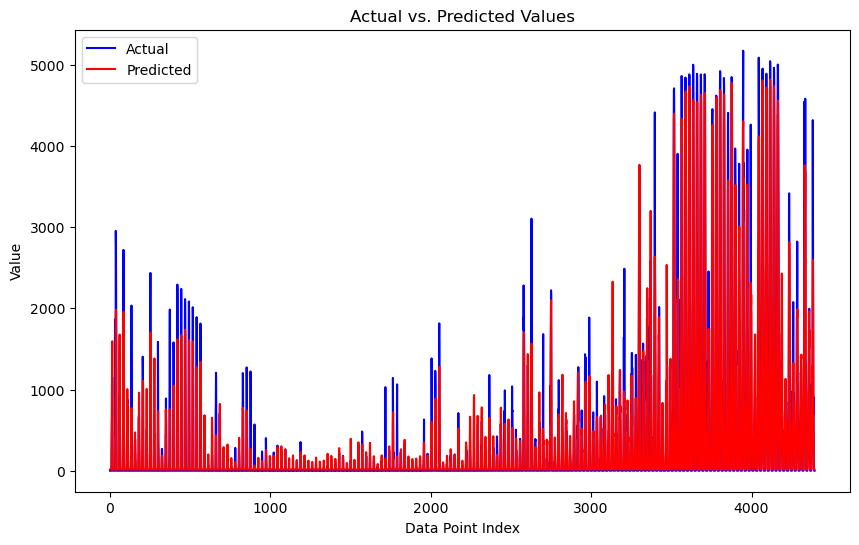

Fitting 1 folds for each of 144 candidates, totalling 144 fits
Best MAE on Validation Set: 15.444296746997166


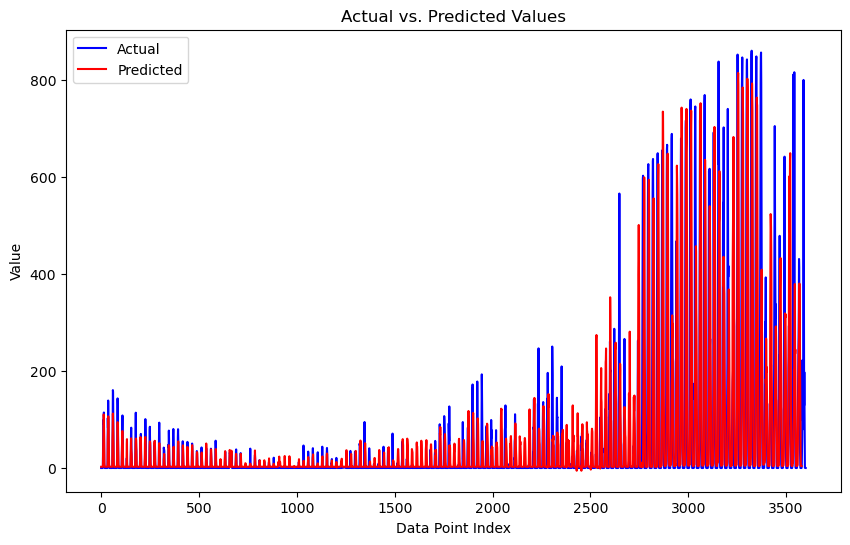

Fitting 1 folds for each of 144 candidates, totalling 144 fits
Best MAE on Validation Set: 18.29385978718155


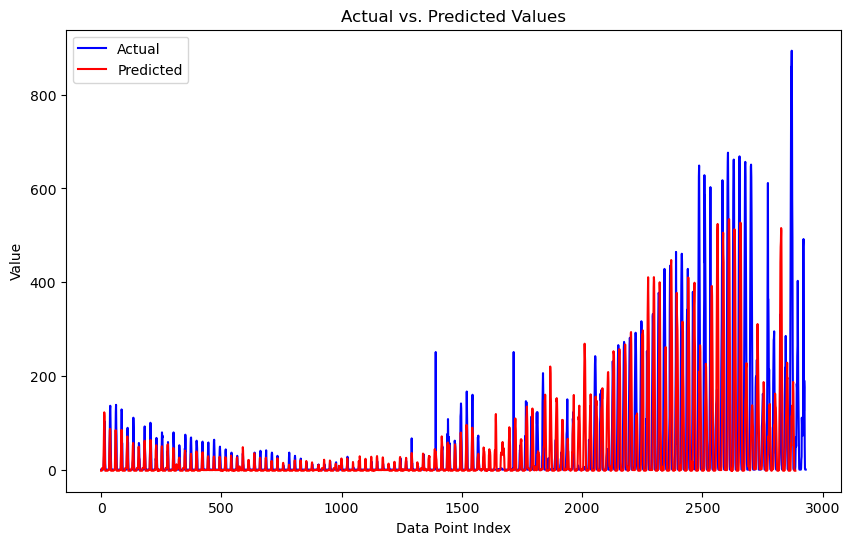

In [140]:
mlp_model_A = train_and_save_mlp_model(X_train_A, y_train_A, X_val_A, y_val_A, 'models/model_location_A.h5')
mlp_model_B = train_and_save_mlp_model(X_train_B, y_train_B, X_val_B, y_val_B, 'models/model_location_B.h5')
mlp_model_C = train_and_save_mlp_model(X_train_C, y_train_C, X_val_C, y_val_C, 'models/model_location_C.h5')

lgbm_model_A = create_and_tune_lgbm(X_train_A, y_train_A, X_val_A, y_val_A)
lgbm_model_B = create_and_tune_lgbm(X_train_B, y_train_B, X_val_B, y_val_B)
lgbm_model_C = create_and_tune_lgbm(X_train_C, y_train_C, X_val_C, y_val_C)

## Predict
Below we have added several ways to predict the values for each model.

In [181]:
# This part shows the prediction when we tried to stack the best mlp models for each location
X_test_meta_A = column_stack([model.predict(X_test_A) for model in models_A])
X_test_meta_B = column_stack([model.predict(X_test_B) for model in models_B])
X_test_meta_C = column_stack([model.predict(X_test_C) for model in models_C])

y_pred_A = meta_learner_A.predict(X_test_meta_A).ravel()
y_pred_B = meta_learner_B.predict(X_test_meta_B).ravel()
y_pred_C = meta_learner_C.predict(X_test_meta_C).ravel()

y_pred_A[y_pred_A < 0] = 0
y_pred_B[y_pred_B < 0] = 0
y_pred_C[y_pred_C < 0] = 0

 1/23 [>.............................] - ETA: 0s

23/23 [==============================] - 0s 309us/step


In [45]:
# This prediction shows a combination of mlp and lgbm models. When other models were implemented we did the same thing
# but with the new model names.
y_pred_a_mlp = mlp_model_A.predict(X_test_A).ravel()
y_pred_b_mlp = mlp_model_B.predict(X_test_B).ravel()
y_pred_c_mlp = mlp_model_C.predict(X_test_C).ravel()

y_pred_a_lgbm = lgbm_model_A.predict(X_test_A).ravel()
y_pred_b_lgbm = lgbm_model_B.predict(X_test_B).ravel()
y_pred_c_lgbm = lgbm_model_C.predict(X_test_C).ravel()

y_pred_a_mlp[y_pred_a_mlp < 0] = 0
y_pred_b_mlp[y_pred_b_mlp < 0] = 0
y_pred_c_mlp[y_pred_c_mlp < 0] = 0

y_pred_a_lgbm[y_pred_a_lgbm < 0] = 0
y_pred_b_lgbm[y_pred_b_lgbm < 0] = 0
y_pred_c_lgbm[y_pred_c_lgbm < 0] = 0

# Compute the geometric mean
y_pred_A = np.power(np.maximum(y_pred_a_lgbm * y_pred_a_mlp, 0), 1/2)
y_pred_B = np.power(np.maximum(y_pred_b_lgbm * y_pred_b_mlp, 0), 1/2)
y_pred_C = np.power(np.maximum(y_pred_c_lgbm * y_pred_c_mlp, 0), 1/2)


23/23 [==============================] - 0s 283us/step


In [183]:
# Here we combine all the predictions from each location to one final submission file with everyone
test_data = pd.read_csv(os.path.join("Submissions", 'test.csv'))
location_a_test = test_data[test_data['location'] == "A"]
location_b_test = test_data[test_data['location'] == "B"]
location_c_test = test_data[test_data['location'] == "C"]

submission_A = pd.DataFrame({'id': location_a_test['id'], 'predicted_values': y_pred_A})
submission_B = pd.DataFrame({'id': location_b_test['id'], 'predicted_values': y_pred_B})
submission_C = pd.DataFrame({'id': location_c_test['id'], 'predicted_values': y_pred_C})

final_submission = pd.concat([submission_A, submission_B, submission_C], ignore_index=True)

final_submission['predicted_values'] = np.where(final_submission['predicted_values'] < 10, 0, final_submission['predicted_values'])

final_submission.to_csv('Submissions/submission_45.csv', index=False)

In [186]:
# This code shows when we manually tried to combine two predictions and took the geometric mean of them
submission_1 = pd.read_csv('Submissions/mlp.csv')
submission_2 = pd.read_csv('Submissions/catboost.csv')  
geom_mean_predictions = gmean([submission_1['predicted_values'], submission_2['predicted_values']], axis=0)

geom_mean_submission = pd.DataFrame({
    'id': submission_1['id'],
    'predicted_values': geom_mean_predictions
})
geom_mean_submission.to_csv('Submissions/geometric_mean_submission1.csv', index=False)